# Small Temporal Density Variations


The following code is used to visualise density varitions from photographs of a moving ridge in the lab. The code firstly takes a background photograph, finds the density profile then compares said profile to photographs taken of the moving ridge.

In [1]:
%matplotlib qt
#notebook backend important
import matplotlib
import numpy as np
import pandas as pd
from scipy import interpolate 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os.path
import cv2
from matplotlib import rc
from tkinter.filedialog import askopenfilename
from tkinter.filedialog import askopenfilenames
import matplotlib.animation as animation
import cmocean as cmo
import time

In [2]:
#A simple function used when clicking of photos to determine where in an array the click is
def index_find(depths,click):
    lst = depths<click
    for i,v in enumerate(lst):
        if v==True:
            return i


## Loading the data from the experiments 

In [3]:
#excel_path = askopenfilename() #path to excel doc with data
excel_path='E:/records.xlsx'
data = pd.read_excel(excel_path)

In [4]:
%matplotlib qt

#run_num = int(input('Run number:'))
#print('Data read')
#getting data from excel doc

run_num=8

rho_bottom = data.iloc[run_num-1, 7]
rho_top = data.iloc[run_num-1, 6]
depth = data.iloc[run_num-1, 2]

## Analysing the background image

In [5]:
#now choose background image, this image should not contain topography

background_path = askopenfilename() 
b_image = cv2.imread(background_path,0)

Now we choose the area of photograph we want to average over to create a background stratification profile. The top of the region should be the free surface and the bottom should be the base of the tank.

In [6]:
plt.figure()
plt.title('Choose Area to Average over')
plt.axis('off')
plt.imshow(b_image, cmap='gist_gray')
print('Select the top then the bottom' )
density_locations = plt.ginput(2)
print('Locations recorded')

zbot_0=int(np.round(density_locations[0][1]))
ztop_0=int(np.round(density_locations[1][1]))

back_crop= b_image[zbot_0:ztop_0,:]

log_back = np.log(back_crop)

#getting rid of unwated inf_values
log_back[np.isinf(log_back)]=np.nan

intensity = np.float32(log_back)
depth_array = -np.linspace(0,depth,intensity.shape[0])

Select the top then the bottom
Locations recorded


In [7]:
#determining the location of density samples top then bottom
length_ratio = depth/intensity.shape[0]

plt.figure()
plt.title('Density Sample Locations')
plt.ylabel('z (m)')
plt.xlabel('x (m)')
plt.imshow(intensity, cmap='gist_gray', extent=[0,length_ratio*intensity.shape[1],-depth,0])
print('Position of density sample close to top, then close to bottom' )
density_locations = plt.ginput(2)
print('Locations recorded')

zbot_rho=index_find(depth_array,density_locations[1][1])
ztop_rho=index_find(depth_array,density_locations[0][1])

middle= int(intensity.shape[1]/2)
intensity_average=np.mean(intensity[:,middle-10:middle+10],axis=1)


beta = (rho_bottom-rho_top)/(intensity_average[zbot_rho]-intensity_average[ztop_rho])
bottom_ref = intensity_average[zbot_rho]

rho_ref=rho_bottom+np.float64(beta*(intensity-bottom_ref))


Position of density sample close to top, then close to bottom
Locations recorded


In [8]:
#now plotting background density field
plt.figure()
im=plt.imshow(rho_ref,vmin=rho_top,vmax=rho_bottom, extent=[0,length_ratio*intensity.shape[1],-depth,0])
plt.title('Background Density')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=plt.colorbar(im, cax=cax)
cbar.set_label(r'Density (kg m$^{-3}$)', rotation=90)
cbar.ax.invert_yaxis()

## Foreground Images
Choose the rapid foreground images you want in order to make a video of the moving ridge in density space


In [9]:
#now choose the pictures you want to look over, also creates a folder to save the video
foreground_path = askopenfilenames()
no_images = len(foreground_path)
os.mkdir('{}/densityfields'.format(os.path.dirname(foreground_path[0])))

In [10]:
%matplotlib inline
print('{} Images to analyse!'.format(no_images))
#inline backend used to stop hundreds of plots occuring, very important!!!!!!!

414 Images to analyse!


C:\Users\u6201343\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
C:\Users\u6201343\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


0 of 414 Images Done!
25 of 414 Images Done!
50 of 414 Images Done!
75 of 414 Images Done!
100 of 414 Images Done!
125 of 414 Images Done!
150 of 414 Images Done!
175 of 414 Images Done!
200 of 414 Images Done!
225 of 414 Images Done!
250 of 414 Images Done!
275 of 414 Images Done!
300 of 414 Images Done!
325 of 414 Images Done!
350 of 414 Images Done!
375 of 414 Images Done!
400 of 414 Images Done!
Saving!


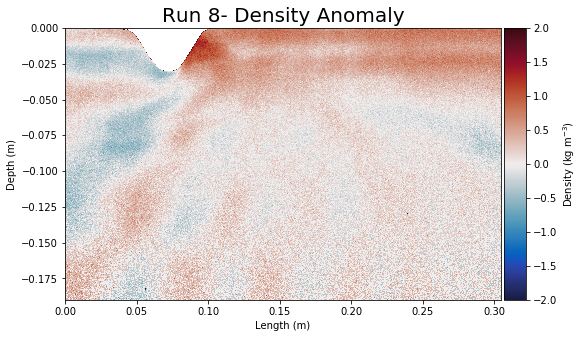

In [11]:
#first doing density

ims=[]
fig = plt.figure(figsize=(10,5))

y,x=rho_ref.shape
#density_anomaly = np.zeros((no_images,y,x))
density_abs = np.zeros((no_images,y,x))


for i in range(no_images):

    f_image=cv2.imread(foreground_path[i],0)
    f_image_crop=f_image[zbot_0:ztop_0,:]
    absorbtion = np.log(f_image_crop)

    #getting rid of unwated inf_values and converting to density
    absorbtion[np.isinf(absorbtion)]=np.nan
    density = rho_bottom+np.float64(beta*(absorbtion-bottom_ref))
    
    
    cmap = cmo.cm.balance
    vmin=-2
    vmax=-vmin
        
    den=density[:,:]-rho_ref
    den[den>4]=np.nan
    density_filt=cv2.medianBlur(np.float32(den[50:,:]),3)
        
    plt_depth=depth
    tank_length=length_ratio*density_filt.shape[1]

    im=plt.imshow(density_filt, cmap=cmap, animated=True, vmin=vmin,vmax=vmax, extent=[0,tank_length,-plt_depth,0])
    title = 'Run {}- Density Anomaly'.format(run_num)
    plt.title(title, fontsize=20)
    
    plt.xlabel('Length (m)')
    plt.ylabel('Depth (m)')
    
    ims.append([im])
    density_abs[i]=density
    if i % 25 == 0:
        print('{} of {} Images Done!'.format(i,no_images))
        
        
ani = animation.ArtistAnimation(fig, ims, interval=125, blit=True,
                                repeat_delay=1000)


ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=plt.colorbar(im, cax=cax)
cbar.set_label(r'Density (kg m$^{-3}$)', rotation=90)


print('Saving!')

writer = animation.writers['ffmpeg']
save_name = 'run_{}_anomaly'.format(run_num)
ani.save('{}/densityfields/{}.mp4'.format(os.path.dirname(foreground_path[0]),save_name), dpi=250)
#np.savez('{}/densityfields/data'.format(os.path.dirname(foreground_path[0])),density_abs=density_abs, rho_ref=rho_ref,depth_array=depth_array, tank_length=tank_length,plt_depth=plt_depth)


Now for abseloute density


C:\Users\u6201343\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\u6201343\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


0 of 414 Images Done!
25 of 414 Images Done!
50 of 414 Images Done!
75 of 414 Images Done!
100 of 414 Images Done!
125 of 414 Images Done!
150 of 414 Images Done!
175 of 414 Images Done!
200 of 414 Images Done!
225 of 414 Images Done!
250 of 414 Images Done!
275 of 414 Images Done!
300 of 414 Images Done!
325 of 414 Images Done!
350 of 414 Images Done!
375 of 414 Images Done!
400 of 414 Images Done!
Saving!


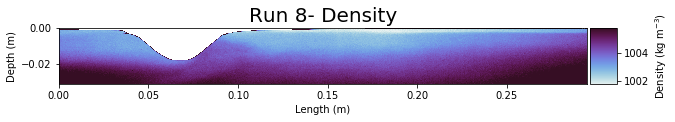

In [12]:
ims=[]
fig = plt.figure(figsize=(10,5))



for i in range(no_images):

    f_image=cv2.imread(foreground_path[i],0)
    f_image_crop=f_image[zbot_0:ztop_0,:]
    absorbtion = np.log(f_image_crop)

    #getting rid of unwated inf_values and converting to density
    absorbtion[np.isinf(absorbtion)]=np.nan
    density = rho_bottom+np.float64(beta*(absorbtion-bottom_ref))
    
    cut=600
    plt_depth=depth/718*(718-cut)
            
    den=density[:,50:-50]
    den[den>rho_bottom+2]=np.nan
    density_filt=cv2.medianBlur(np.float32(den[:cut,:]),3)

    
    tank_length=length_ratio*density_filt.shape[1]
    
    cmap = cmo.cm.dense
    vmin=rho_top
    vmax=rho_top+4
        
  

    im=plt.imshow(density_filt, cmap=cmap, animated=True, vmin=vmin,vmax=vmax, extent=[0,tank_length,-plt_depth,0])
    title = 'Run {}- Density'.format(run_num)
    plt.title(title, fontsize=20)
    
    plt.xlabel('Length (m)')
    plt.ylabel('Depth (m)')
    
    ims.append([im])

    
    if i % 25 == 0:
        print('{} of {} Images Done!'.format(i,no_images))
        
        
ani = animation.ArtistAnimation(fig, ims, interval=125, blit=True,
                                repeat_delay=1000)


ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=plt.colorbar(im, cax=cax)
cbar.set_label(r'Density (kg m$^{-3}$)', rotation=90)


print('Saving!')

writer = animation.writers['ffmpeg']
save_name = 'run_{}_abs'.format(run_num)
ani.save('{}/densityfields/{}.mp4'.format(os.path.dirname(foreground_path[0]),save_name), dpi=250)

## Making a Steady Image

As seen in the videos produced above the hill is moving, for filtering and visualistion purposes it would be convienent if the hill was stationairy and the fluid moved. The code below does this. In short it sets the topography to Nan, then sums the Nans in the vertical direction in order to find the locations in x where the topography is 'most present'. I find the average location of the maximal Nan area and then crop the flow fields to keep the topography in the same spot. 

In [196]:
cropped_density = density_abs[:,:600,:] #removing bottom portion of field as unwanted
cropped_density[cropped_density>rho_bottom-3]=np.nan #setting topo to nan

t,y,x=cropped_density.shape
topo_location = np.zeros(t) #array to store top of topo location for each image

for i in range(t):
    image=cropped_density[i]
    
    nan_count=np.float32(np.sum(np.isnan(image),axis=0)) #summing the Nans in the vertical direction
    nan_count[nan_count<336]=np.nan #removing everything but the top of the hill
    nan_count=nan_count*0+1
    nan_count=nan_count*np.arange(x) #creating an array where the value is the index
    
    max_loc = np.nanmean(nan_count) #finding the average index of top of the hill
    topo_location[i]=max_loc

C:\Users\u6201343\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


Text(0, 0.5, 'Topography Location (Pixel)')

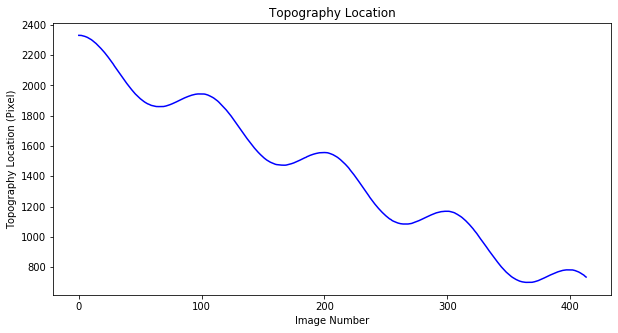

In [18]:
#Plotting topo location to check it looks alright
plt.figure(figsize=(10,5))
plt.plot(topo_location,color='b')
plt.title('Topography Location')
plt.xlabel('Image Number')
plt.ylabel('Topography Location (Pixel)')

In [24]:
#now cropping images keeping the centre location constant

right = int(x-max(topo_location))
left = int(min(topo_location))

centre_rho=np.zeros((t,y,right+left))
centre_anom=np.zeros((t,y,right+left))

for i in range(t):
    topo=int(topo_location[i])
    
    image=cropped_density[i]
    
    cropped_image=image[:,int(topo-left):int(topo+right)]
    cropped_ref=rho_ref[:600,int(topo-left):int(topo+right)]
    
    centre_rho[i]=cropped_image
    centre_anom[i]=cropped_image-cropped_ref

0 of 414 Images Done!
25 of 414 Images Done!
50 of 414 Images Done!
75 of 414 Images Done!
100 of 414 Images Done!
125 of 414 Images Done!
150 of 414 Images Done!
175 of 414 Images Done!
200 of 414 Images Done!
225 of 414 Images Done!
250 of 414 Images Done!
275 of 414 Images Done!
300 of 414 Images Done!
325 of 414 Images Done!
350 of 414 Images Done!
375 of 414 Images Done!
400 of 414 Images Done!
Saving!


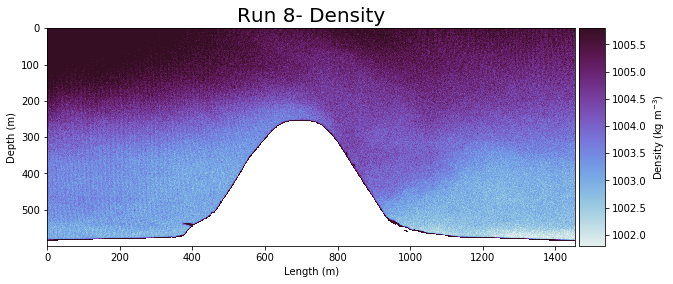

In [26]:
#using the same code as above to create a video to look at centred topo for abs
ims=[]
fig = plt.figure(figsize=(10,5))

for i in range(t):
    
    image=centre_rho[i][::-1]
    
    cmap = cmo.cm.dense
    vmin=rho_top
    vmax=rho_top+4
        

    im=plt.imshow(image, cmap=cmap, animated=True, vmin=vmin,vmax=vmax)
    title = 'Run {}- Density'.format(run_num)
    plt.title(title, fontsize=20)
    
    plt.xlabel('Length (m)')
    plt.ylabel('Depth (m)')
    
    ims.append([im])

    
    if i % 25 == 0:
        print('{} of {} Images Done!'.format(i,t))
        
        
ani = animation.ArtistAnimation(fig, ims, interval=125, blit=True,
                                repeat_delay=1000)

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=plt.colorbar(im, cax=cax)
cbar.set_label(r'Density (kg m$^{-3}$)', rotation=90)


print('Saving!')

writer = animation.writers['ffmpeg']
save_name = 'centre_rho'.format(run_num)
ani.save('{}/densityfields/{}.mp4'.format(os.path.dirname(foreground_path[0]),save_name), dpi=250)

0 of 414 Images Done!
25 of 414 Images Done!
50 of 414 Images Done!
75 of 414 Images Done!
100 of 414 Images Done!
125 of 414 Images Done!
150 of 414 Images Done!
175 of 414 Images Done!
200 of 414 Images Done!
225 of 414 Images Done!
250 of 414 Images Done!
275 of 414 Images Done!
300 of 414 Images Done!
325 of 414 Images Done!
350 of 414 Images Done!
375 of 414 Images Done!
400 of 414 Images Done!
Saving!


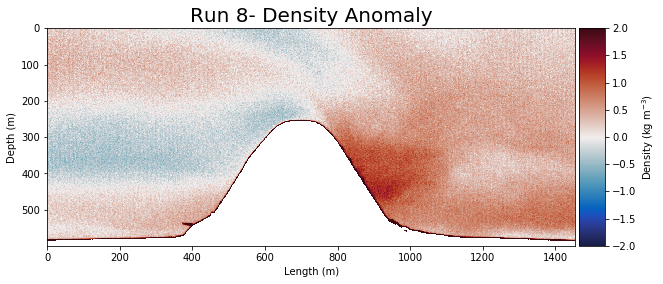

In [27]:
ims=[]
fig = plt.figure(figsize=(10,5))

for i in range(t-2):
    
    image=centre_anom[i][::-1]
    
    cmap = cmo.cm.balance
    vmin=-2
    vmax=-vmin
        
    density_filt=cv2.medianBlur(np.float32(image),3)
        
    plt_depth=depth
    tank_length=length_ratio*density_filt.shape[1]

    im=plt.imshow(density_filt, cmap=cmap, animated=True, vmin=vmin,vmax=vmax)
    title = 'Run {}- Density Anomaly'.format(run_num)
    plt.title(title, fontsize=20)
    
    plt.xlabel('Length (m)')
    plt.ylabel('Depth (m)')
    
    ims.append([im])
    density_abs[i]=density
    if i % 25 == 0:
        print('{} of {} Images Done!'.format(i,no_images))
        
        
ani = animation.ArtistAnimation(fig, ims, interval=125, blit=True,
                                repeat_delay=1000)


ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=plt.colorbar(im, cax=cax)
cbar.set_label(r'Density (kg m$^{-3}$)', rotation=90)


print('Saving!')

writer = animation.writers['ffmpeg']
save_name = 'run_{}_anomaly_centre'.format(run_num)
ani.save('{}/densityfields/{}.mp4'.format(os.path.dirname(foreground_path[0]),save_name), dpi=250)

In [28]:
#saving some key stuff, to be loaded later if needed

np.savez('{}/densityfields/data'.format(os.path.dirname(foreground_path[0])),centre_anom=centre_anom, cropped_ref=cropped_ref)

## Finding Velocities 

Plan to use:

$\frac{D b}{D t}+N^2(z)w\approx 0,$

 to determine $w$. This yields:
 
 $w=-\frac{1}{N^2}\frac{D b}{D t},$

and then use $\nabla \mathbf{u}=0$ to determine $u$. 

This method does assume there is negligible mixing and is not yet fully implimented. Going to using background stratification to determine N, looks like there is two distinct regions- the thermocline where $N^2=0$ and below the thermocline where $N$ is stable $(N^2>0)$.




In [5]:
data_path = askopenfilename()
data=np.load(data_path)

In [6]:
centre_anom=data['centre_anom'][:,20:,:]
cropped_ref=data['cropped_ref'][20:,:]


In [7]:
g = 9.81
n=np.sqrt(g/1000*(rho_bottom-rho_top)/depth)
%matplotlib inline

In [8]:
t,y,x=centre_anom.shape
t=t-1
w=np.zeros((t,y,x))
w_filt=np.zeros((t,y,x))
delta_t=0.125
sf=1 #need to change!!!!
scaling = -sf/n**2

for i in range(t):
    diff = (centre_anom[i+1]-centre_anom[i])/delta_t
    w[i] = np.float32(diff*scaling)
    w_filt[i] = cv2.medianBlur(np.float32(diff*scaling),3)

In [9]:
test_raw=w[10]
test_post_filt=cv2.medianBlur(np.float32(w[10]),3)
test_pre_filt=w_filt[10]
test_pre_post_filt=cv2.medianBlur(np.float32(w_filt[10]),3)

Text(0.5, 1.0, 'Filtered Before and After Differentiation')

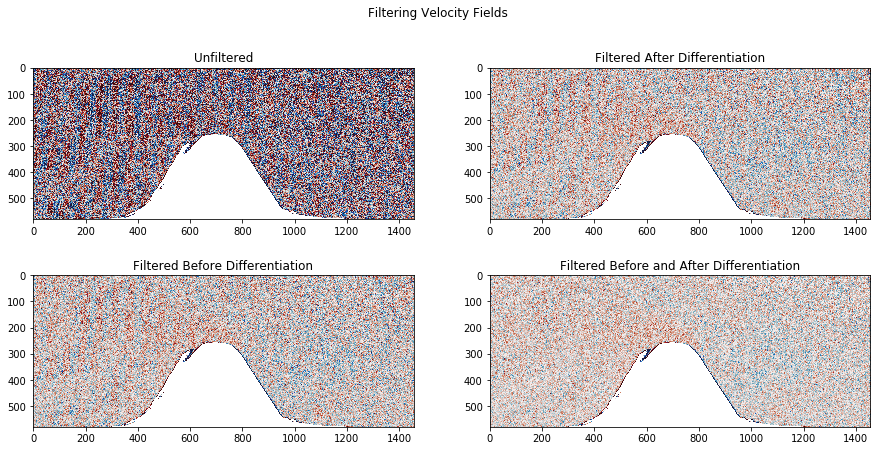

In [10]:
fig = plt.figure(figsize=(15,7))
fig.suptitle("Filtering Velocity Fields")
             
gs = GridSpec(nrows=2, ncols=2)

max_val = 5
cmap = cmo.cm.balance
    
ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(test_raw[::-1],vmin=-max_val,vmax=max_val, cmap=cmap)
ax0.set_title('Unfiltered')

ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(test_post_filt[::-1],vmin=-max_val,vmax=max_val, cmap=cmap)
ax1.set_title('Filtered After Differentiation')

ax2 = fig.add_subplot(gs[1, 0])
ax2.imshow(test_pre_filt[::-1],vmin=-max_val,vmax=max_val, cmap=cmap)
ax2.set_title('Filtered Before Differentiation')

ax3 = fig.add_subplot(gs[1, 1])
ax3.imshow(test_pre_post_filt[::-1],vmin=-max_val,vmax=max_val, cmap=cmap)
ax3.set_title('Filtered Before and After Differentiation')


## Filtering Data

As seen in the plots above, we clearly need a better method for filtering the data. As the data appears to be overlaid with high frequency noise filtering in fourier space seems like a good idea. Below we first find an equation for the topography, then transform the data to a rectangular domain that contains no topography. We then interpolate the values to fix the Nan's then from a fourier transform and use a low pass filter on the data set

### Topography Equation

In [12]:
#topography function
domain=np.arange(x)
alpha,mu,sigma=350,695,180
topo_function=-alpha*np.exp(-(domain-mu)**2/(2*sigma**2))+y



Text(0.5, 1.0, '$f(x)$ with Dummy Data')

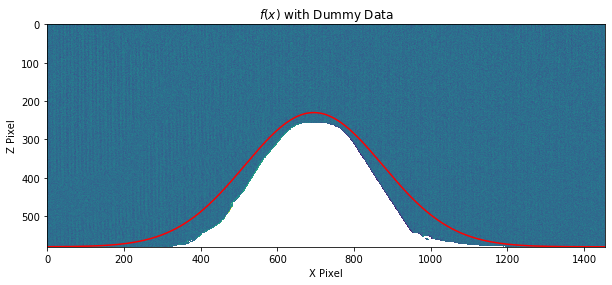

In [54]:
#plotting topo function with data
plt.figure(figsize=(10,6))
plt.imshow(w[100][::-1])
plt.plot(topo_function, color='r')
plt.ylim(580,0)
plt.xlabel('X Pixel')
plt.ylabel('Z Pixel')
plt.title(r'$f(x)$ with Dummy Data')

### Transforming the data

In [25]:
#creating a meshgrid of pixel locations
x_array = np.arange(x)
z_array = np.arange(z)

xx,zz=np.meshgrid(x_array,z_array)

In [26]:
#creating and filling zt (z transformed) an array that contains the new z location for each z in zz
zt=np.zeros((z,x))
for i in range(x):
    topo=topo_function[i]
    transformed_array=z*(zz[:,i]-topo)/(-topo) #function
    zt[:,i]=-np.round(transformed_array)+z

(580, 0)

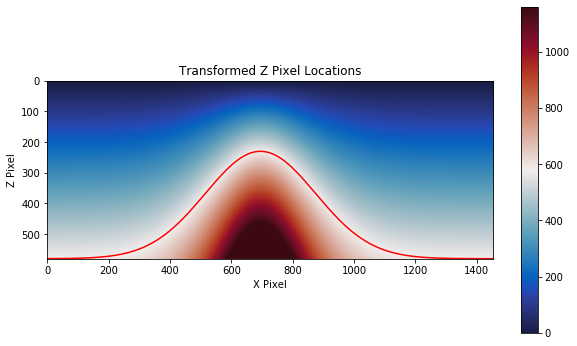

In [52]:
#plotting transformed coordinates
plt.figure(figsize=(10,6))
plt.imshow(zt, cmap=cmo.cm.balance, vmin=0, vmax=580*2)
plt.plot(topo_function, color='r')
plt.xlabel('X Pixel')
plt.ylabel('Z Pixel')
plt.title('Transformed Z Pixel Locations')
plt.colorbar()
plt.ylim(580,0)

In [31]:
#creating and filling a new transformed array that usese the values from zt
transformed = np.zeros((y,x))

for i in range(x):
    for j in range(z):
        data=base[j,i]
        z_loc = int(zt[j,i])
        
        if z_loc<580:
            transformed[z_loc,i]=data

transformed[transformed==0]=np.nan

Text(0, 0.5, 'Z Pixel')

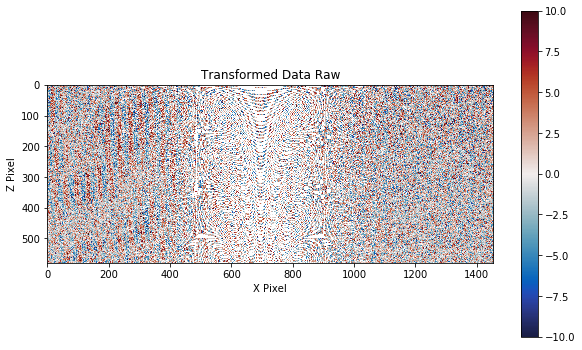

In [56]:
plt.figure(figsize=(10,6))
plt.imshow(transformed,vmin=-10,vmax=10,cmap=cmo.cm.balance)
plt.colorbar()
plt.title('Transformed Data Raw')
plt.xlabel('X Pixel')
plt.ylabel('Z Pixel')

### Interpolating Data

As seen in the plot above we need to interpolate the data to remove the Nan's present in the signal (or else Fourier transform will not work).